<a href="https://colab.research.google.com/github/EsmirMes/CS159/blob/main/q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 159 · Homework 3 · Question 5**



## Imports

In [ ]:
import math
import numpy as np
from tqdm.notebook import tqdm

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

## Define MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, depth, width):
        super(MLP, self).__init__()

        self.initial = nn.Linear(3072, width, bias=False)
        self.layers = nn.ModuleList([nn.Linear(width, width, bias=False) for _ in range(depth-2)])
        self.final = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        x = self.initial(x)
        x = F.relu(x) * math.sqrt(2)
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x) * math.sqrt(2)
        return self.final(x)

## Get a CIFAR-10 image and create three more noisy copies






Extracting ./data/cifar-10-python.tar.gz to ./data


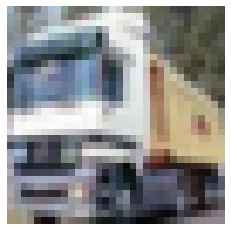

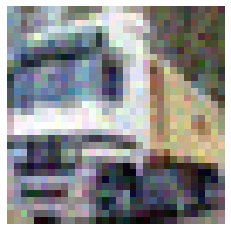

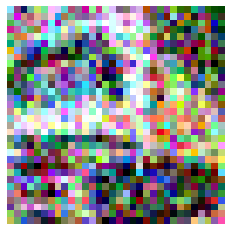

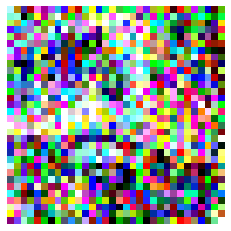

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

image = trainset[1][0].permute(1,2,0).clamp_(0,1)

# create noisy images
image_ = (image + torch.randn_like(image)*0.05).clamp_(0,1)
image__ = (image + torch.randn_like(image)*0.25).clamp_(0,1)
image___ = (image + torch.randn_like(image)*0.5).clamp_(0,1)

# plot images
plt.axis('off'); plt.imshow(image); plt.show()
plt.axis('off'); plt.imshow(image_); plt.show()
plt.axis('off'); plt.imshow(image__); plt.show()
plt.axis('off'); plt.imshow(image___); plt.show()

# flatten images to pass through MLP
image = image.flatten().unsqueeze(0)
image_ = image_.flatten().unsqueeze(0)
image__ = image__.flatten().unsqueeze(0)
image___ = image___.flatten().unsqueeze(0)

# concatenate into single batch
input = torch.cat((image,image_,image__,image___), 0)

# rescale inputs to get a well scaled output
input /= input.norm(dim=1, keepdim=True) 
input *= math.sqrt(input.shape[1])

## Sample random MLPs and pass the inputs through

In [ ]:
depth = 3
net = MLP(width=1000,depth=depth)

print("The network matrices have shapes:\n")
for p in net.parameters():
    print(p.shape)

print("\nSampling random networks...\n")

num_inputs = input.shape[0]
num_random_networks = 1000
output = torch.zeros(num_inputs, num_random_networks)

for network_idx in tqdm(range(num_random_networks)):
    
    # randomly sample network weights
    for p in net.parameters():
        p.data = torch.randn_like(p) / math.sqrt(p.shape[1])
    
    # pass input through network
    output[:, network_idx] = net(input).squeeze().detach()

The network matrices have shapes:

torch.Size([1000, 3072])
torch.Size([1000, 1000])
torch.Size([1, 1000])

Sampling random networks...



## TODO: compute the sample covariance of outputs
Hint: use Pytorch built-in functions. We implemented this in 3 lines of code.

In [24]:
cov_sample = np.cov(output)
print(cov_sample)

[[1.03190862 1.02749938 0.97835251 0.89946144]
 [1.02749938 1.02987598 0.97507153 0.89700953]
 [0.97835251 0.97507153 1.04089353 0.87285577]
 [0.89946144 0.89700953 0.87285577 1.02651087]]


## TODO: compute the theoretical output covariance
Hint: we implemented this in one line.

In [ ]:
# the following function may help you. It operates elementwise on Pytorch tensors.
def h(t):
    t = t.clamp(min=-1, max=1) # sanitise the input
    return 1/math.pi * ((1-t**2).sqrt() + t*(math.pi - t.acos()))

In [26]:
cov = torch.matmul(input, input.T) / input.shape[1]
for _ in range(depth - 1):
    cov = h(cov)
cov

tensor([[1.0000, 0.9964, 0.9414, 0.8743],
        [0.9964, 1.0000, 0.9385, 0.8720],
        [0.9414, 0.9385, 1.0000, 0.8410],
        [0.8743, 0.8720, 0.8410, 1.0000]])

In [25]:
# More complex numpy way:
def comp(x_i, x_j):
    val = torch.from_numpy(np.array([np.dot(x_i.T, x_j)])) / input.shape[1]
    for i in range(depth - 1):
        val = h(val)
    return val
        
cov_theoretical = np.array([[comp(input[i], input[j]).tolist()[0] for j in range(len(input))] for i in range(len(input))])
print(cov_theoretical)

[[1.         0.99639136 0.94140959 0.87426507]
 [0.99639136 0.99999982 0.93851256 0.87202287]
 [0.94140959 0.93851256 1.         0.84095532]
 [0.87426507 0.87202287 0.84095532 0.9999997 ]]
